# Initialize and cleaning of play-by-play data

## Load the data

In [1]:
#Imports
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
# import os
# import scipy
# import urllib.request
# from matplotlib.offsetbox import OffsetImage, AnnotationBbox
# import matplotlib as mpl
# from scipy.interpolate import make_interp_spline, BSpline
# from adjustText import adjust_text

%config InlineBackend.figure_format = 'retina'

In [2]:
#hardcode colors
colors = {
    'ARI':'#97233F',
    'ATL':'#A71930',
    'BAL':'#241773',
    'BUF':'#00338D',
    'CAR':'#0085CA',
    'CHI':'#C83803',
    'CIN':'#FB4F14',
    'CLE':'#311D00',
    'DAL':'#041E42',
    'DEN':'#FB4F14',
    'DET':'#0076B6',
    'GB' :'#203731',
    'HOU':'#03202F',
    'IND':'#002C5F',
    'JAX':'#006778',
    'KC' :'#E31837',
    'LAC':'#0080C6',
    'LAR':'#866D4B',
    'MIA':'#008E97',
    'MIN':'#4F2683',
    'NE' :'#002244',
    'NO' :'#D3BC8D',
    'NYG':'#0B2265',
    'NYJ':'#125740',
    'OAK':'#A5ACAF',
    'PHI':'#004C54',
    'PIT':'#FFB612',
    'SEA':'#69BE28',
    'SF' :'#AA0000',
    'TB' :'#D50A0A',
    'TEN':'#0C2340',
    'WAS':'#773141'
}

kc_p = '#E31837'
kc_s = '#FFB81C'

In [3]:
#load data
data = pd.read_csv('clean_pbp_2019_wk20.csv',low_memory=False)

# Analysis

In [4]:
#some minor feature engineering
data.loc[data['interception']==1, 'complete_pass'] = 0
data['cpoe'] = data['complete_pass'] - data['cp']

In [5]:
#Fixing old team naming conventions
data.loc[(data['posteam']=='LA'),'posteam'] = 'LAR'
data.loc[(data['posteam']=='SD'),'posteam'] = 'LAC'
data.loc[(data['posteam']=='JAC'),'posteam'] = 'JAX'
data.loc[(data['posteam']=='STL'),'posteam'] = 'LAR'

In [23]:
#get all postseason dropbacks
postseason_passes = data.loc[(data['pass']==1) & (data['week']>=18)]
#Group by who throw the pass
qbs = postseason_passes.groupby(by=['name','posteam'])['epa','success','air_yards','cpoe','yards_after_catch'].mean()
#Get number of attempts, so we can filter out QBs who have only thrown a few passes
qbs['attempts'] = postseason_passes.groupby(by=['name','posteam'])['epa'].count()
qbs.reset_index(inplace=True)
qbs = qbs.loc[(qbs['attempts']>=20)]

In [25]:
qbs.sort_values(by=['epa'],ascending=False,inplace=True)

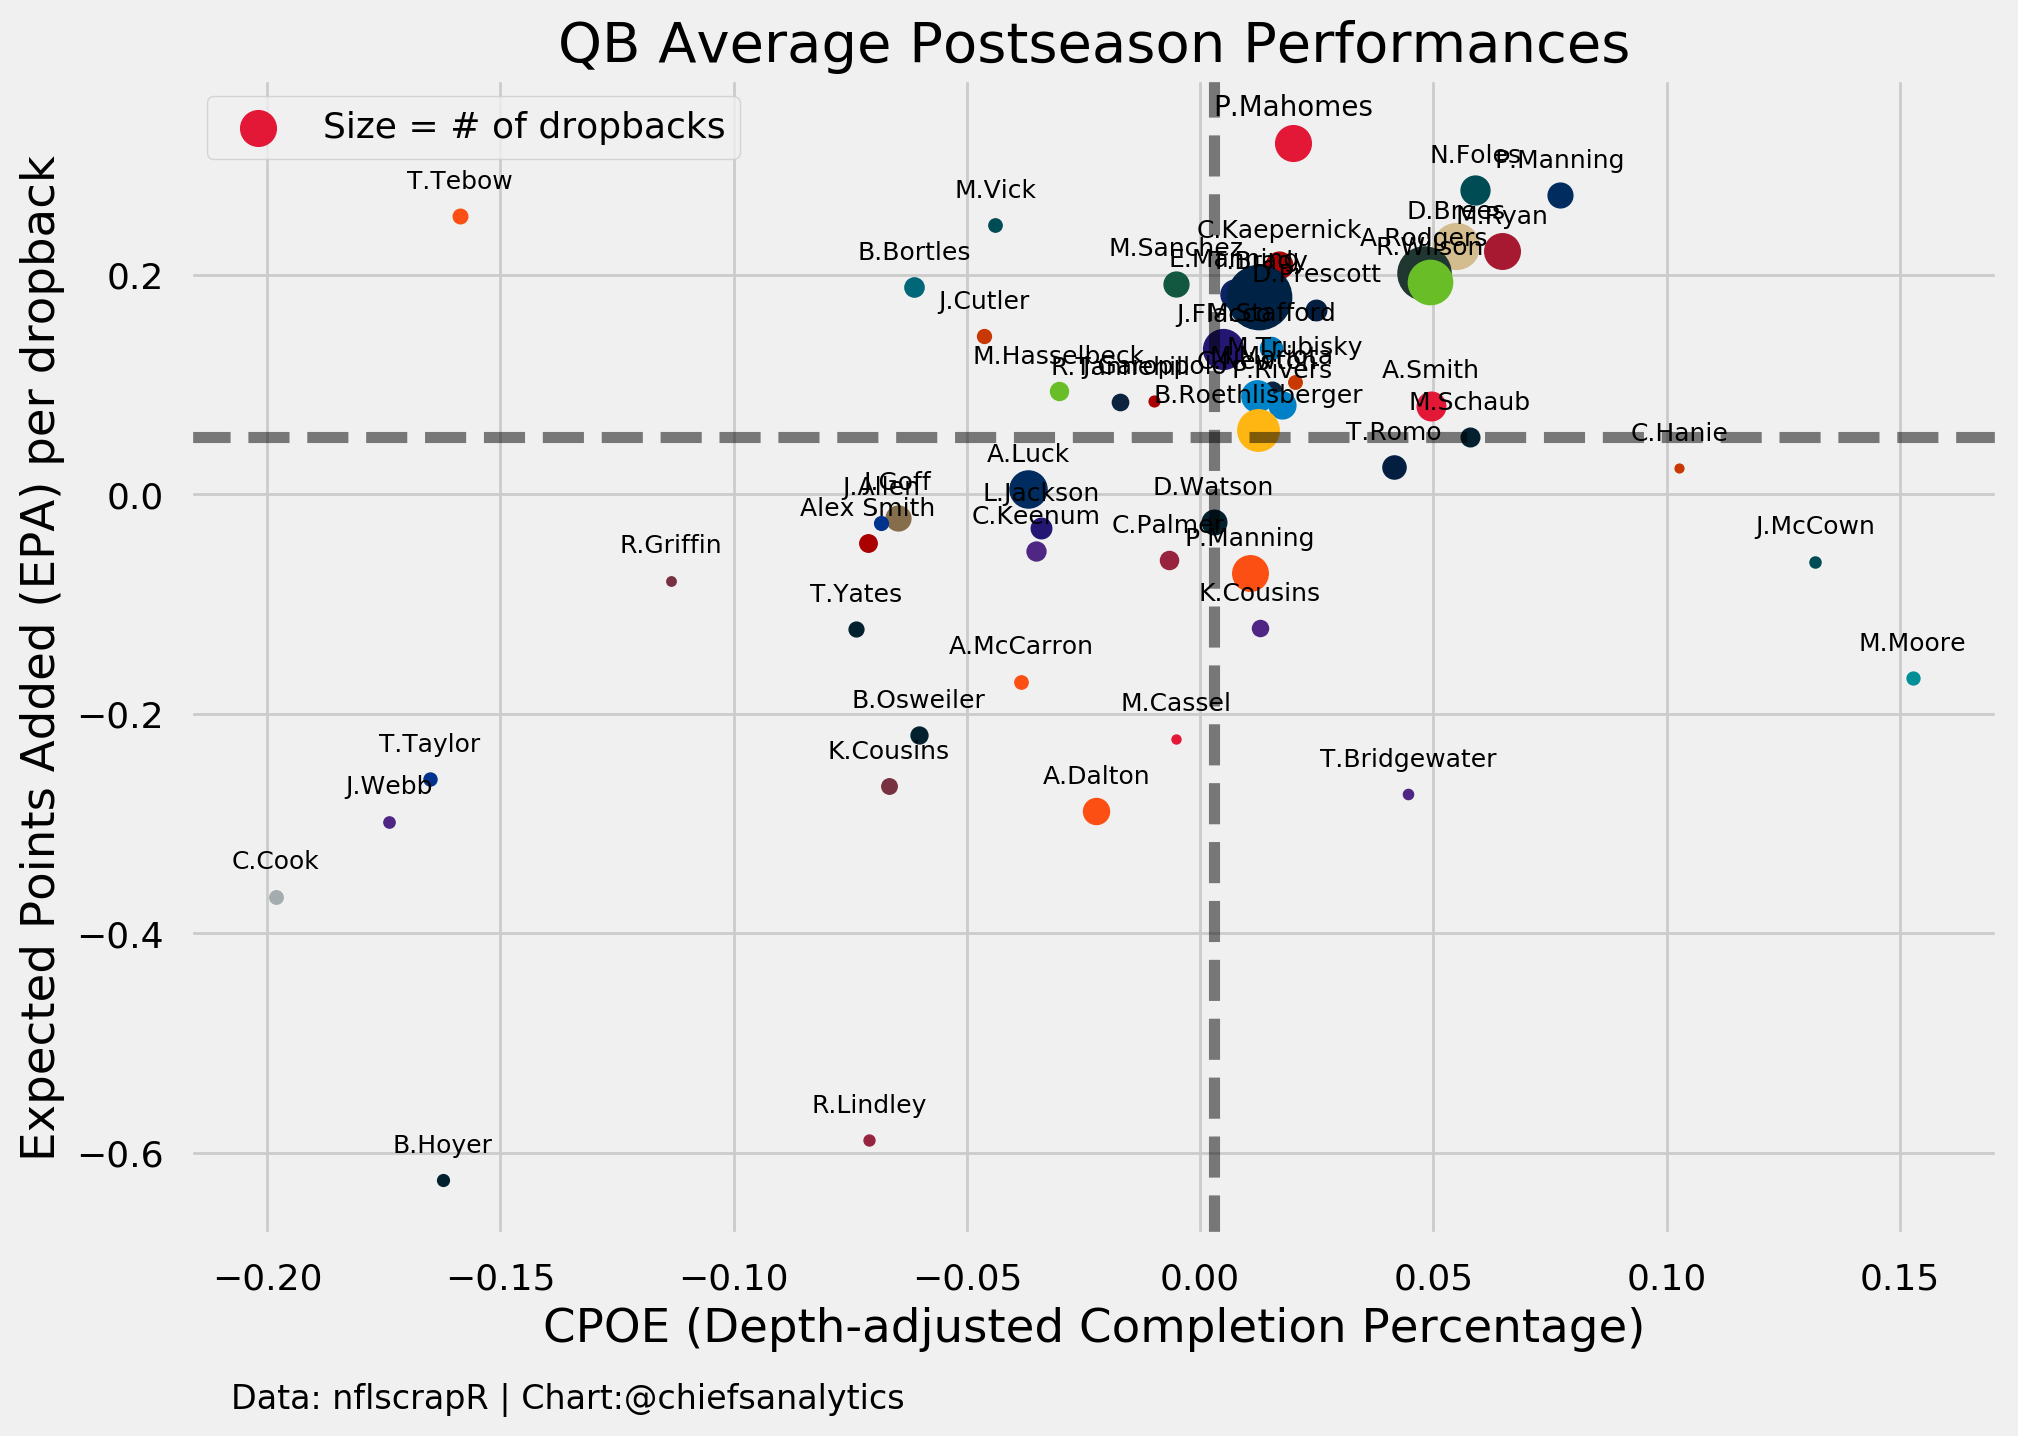

In [30]:
#Plotting
plt.style.use('default')
plt.style.use('seaborn-talk')
plt.style.use('fivethirtyeight')
#Plot 50th% of our variables
plt.axvline(qbs['cpoe'].median(),ls='--',c='k',alpha=0.5)
plt.axhline(qbs['epa'].median(),ls='--',c='k',alpha=0.5)
#Going to do something different for Mahomes, so grabbing his row separately
mahomes = qbs.iloc[0]
#Loop to plot each QB - this isn't at all necessary, but i keep this structure for when I am doing team color plots
for index,qb in qbs.iterrows():
    if qb['name']=='P.Mahomes':
        continue
    plt.scatter(qb['cpoe'], qb['epa'], c=colors[qb['posteam']], 
                s=qb['attempts']*0.5, alpha=1)
    plt.annotate(qb['name'], # this is the text
            (qb['cpoe'],qb['epa']), # this is the point to label
            textcoords="offset points", # how to position the text
            xytext=(0,10), # distance from text to points (x,y)
            ha='center',fontsize = 9,
            alpha=1) # horizontal alignment can be left, right or center     
#Plot mahomes
plt.scatter(mahomes['cpoe'],mahomes['epa'], c=kc_p, s=mahomes['attempts']*1,label='Size = # of dropbacks')
plt.annotate('P.Mahomes',
            (mahomes['cpoe'],mahomes['epa']),
            textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',fontsize = 10)


#Title, labels
plt.title('QB Average Postseason Performances')
plt.ylabel('Expected Points Added (EPA) per dropback')
plt.xlabel('CPOE (Depth-adjusted Completion Percentage)')
txt = "Data: nflscrapR | Chart:@chiefsanalytics"
plt.figtext(0.1, -0.05, txt, wrap=True, horizontalalignment='left', fontsize=12)
plt.legend(loc='upper left')